# Simulação do nível de dois tanques com uma PINN


## 1. Importa bibliotecas e configurações básicas


In [1]:
from typing import Any

import numpy as np
import torch

from lib.export_params import models_folder

# Ativando otimizações
from lib.utils import enable_optimizations

enable_optimizations()

# Setando sementes
np.random.seed(42)
torch.manual_seed(42)

# Configurando tipo das variáveis
dtype = torch.float32
torch.set_default_dtype(dtype)


# Definido vazão de entrada
def q_train(t, op: Any = np):
    output = op.ones_like(t) * 24
    output = op.where(t >= 100, 34, output)
    output = op.where(t >= 1000, 24, output)

    return output


# Definindo nome do modelo
model_name = "pinn"
model_path = f"{models_folder}{model_name}.pt"


## 2. Calcula a solução numérica


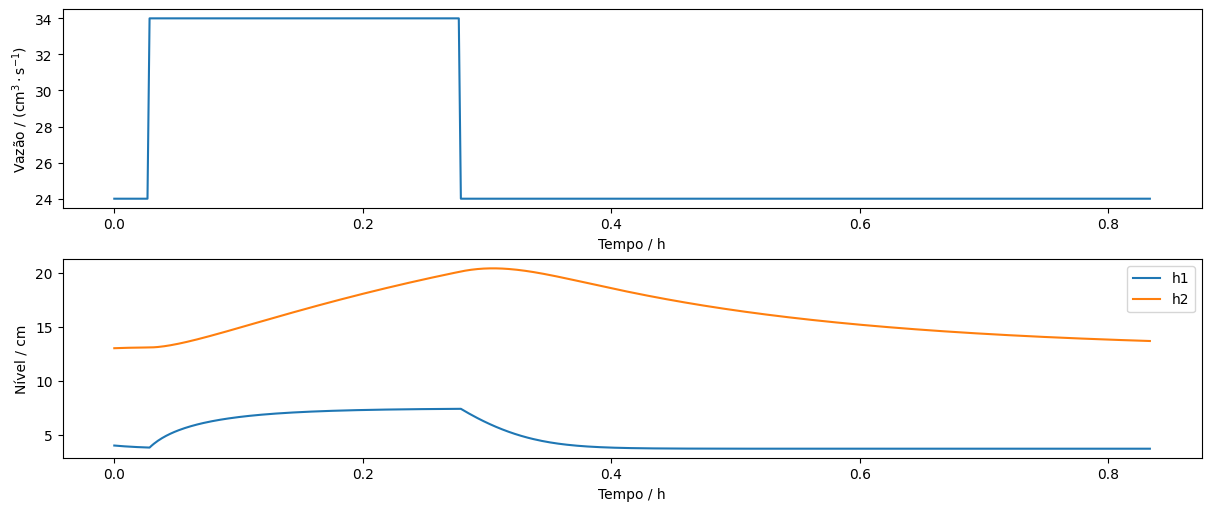

In [2]:
from lib.common_plots import plot_flow_and_level
from lib.physical_systems import Spherical_tanks

tanks = Spherical_tanks()
tanks.set_simulation_parameters(q_train, [0, 3000], 500, y0=[4, 13])
h_cas = tanks.simulate_casadi("rk")

h1_cas, h2_cas = torch.tensor(h_cas, dtype=torch.float32)

plot_flow_and_level(
    tanks.t_numpy,
    q_train(tanks.t_numpy),
    h_cas,
    ["h1", "h2"],
)


## 3. Cria a rede neural


In [3]:
from lib.models import FNN, DataInfo

normalization_data: DataInfo = {
    "in_min": torch.tensor([tanks.t_torch[0]], dtype=torch.float32),
    "in_max": torch.tensor([tanks.t_torch[-1]], dtype=torch.float32),
    "out_min": torch.tensor([tanks.h_min, tanks.h_min], dtype=torch.float32),
    "out_max": torch.tensor([tanks.h_max, tanks.h_max], dtype=torch.float32),
}

model = FNN(1, 32, 2, normalization_data)


## 4. Treina a rede neural


In [4]:
import os

from lib.common_plots import plot_loss
from lib.utils import dydx, mean_square, notify_training_end


def loss_fn(model, t):
    # Loss das EDOs
    Y_pred = model(t)
    h1_pred, h2_pred = Y_pred[:, 0:1], Y_pred[:, 1:]

    dh1dt_pinn, dh2dt_pinn = dydx(t, h1_pred), dydx(t, h2_pred)
    dh1dt_edo, dh2dt_edo = tanks.edo_torch(t, Y_pred)

    loss_EDO1 = mean_square(dh1dt_pinn - dh1dt_edo)
    loss_EDO2 = mean_square(dh2dt_pinn - dh2dt_edo)

    # Initial condition loss
    t0 = torch.tensor([[0.0]], requires_grad=True)
    Y0 = model(t0)
    h1_0, h2_0 = Y0[:, 0:1], Y0[:, 1:]

    loss_ic1 = mean_square(h1_0 - tanks.y0[0])
    loss_ic2 = mean_square(h2_0 - tanks.y0[1])

    # Loss dos dados
    data_h1 = mean_square(h1_pred.squeeze() - h1_cas)
    data_h2 = mean_square(h2_pred.squeeze() - h2_cas)

    # Loss total
    loss_total = (
        loss_EDO1 * 100  #
        + loss_EDO2 * 100
        + loss_ic1
        + loss_ic2
        + data_h1
        + data_h2
    )

    return loss_total, [
        loss_EDO1.detach() * 100,
        loss_EDO2.detach() * 100,
        loss_ic1.detach(),
        loss_ic2.detach(),
        data_h1.detach(),
        data_h2.detach(),
    ]


tensor_t = tanks.t_torch.unsqueeze(1).clone().detach().requires_grad_(True)

if not os.path.exists(model_path):
    print("Não foi possível recuperar os parâmetros")
    print("Treinando o modelo...")

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.7, 0.8))
    history = model.fit(optimizer, loss_fn, 5000, (tensor_t))

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    history.extend(model.fit(optimizer, loss_fn, 2000, (tensor_t)))

    notify_training_end()

    plot_loss(
        history[:300],
        [
            "Loss EDO 1",
            "Loss EDO 2",
            "Loss IC 1",
            "Loss IC 2",
            "Loss DADOS 1",
            "Loss DADOS 2",
        ],
        "pinn-loss",
    )

    torch.save(model.state_dict(), model_path)
else:
    print("Recuperando os parâmetros do modelo...")
    model.load_state_dict(torch.load(model_path, weights_only=True))
    print("Parâmetros recuperados. Não será necessário reexecutar o treinamento.")


Recuperando os parâmetros do modelo...
Parâmetros recuperados. Não será necessário reexecutar o treinamento.


## 5. Testa a PINN


torch.Size([500]) torch.Size([500])


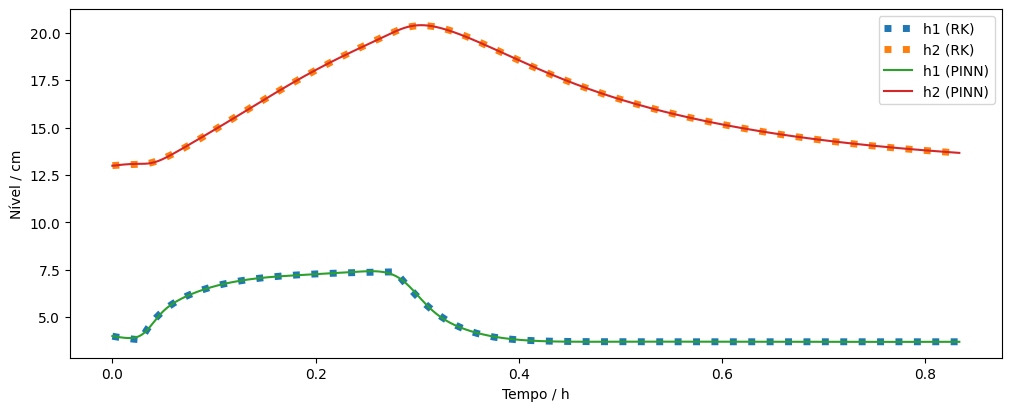

In [5]:
from lib.common_plots import plot_tanks


@torch.inference_mode()
def test_pytorch(t):
    y = model(t)
    return [y[:, :1], y[:, 1:]]


pinn_h1, pinn_h2 = test_pytorch(tensor_t)
print(h1_cas.shape, h2_cas.shape)

# Gráfico
plot_tanks(
    tanks.t_numpy,
    (h1_cas, h2_cas, pinn_h1, pinn_h2),
    ["h1 (RK)", "h2 (RK)", "h1 (PINN)", "h2 (PINN)"],
    2,
    "pinn-result",
)


# Benchmarking com outros métodos


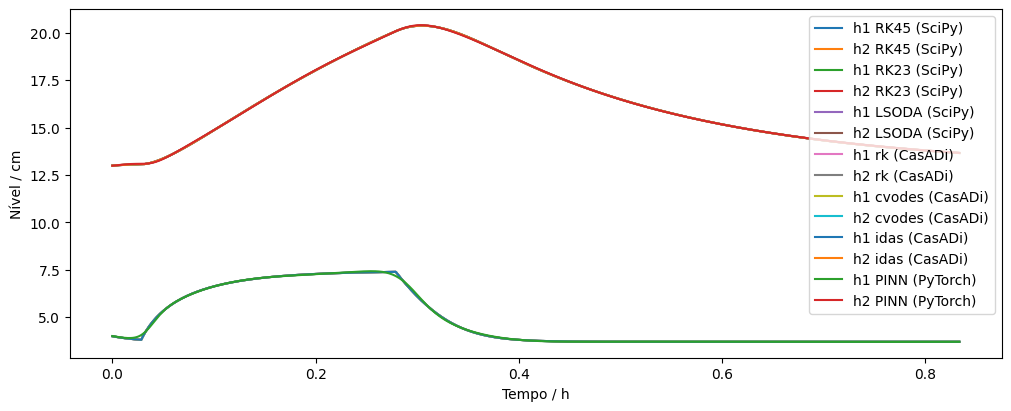

Recuperando medições


In [6]:
import hickle as hkl
import seaborn as sns
from drawarrow import fig_arrow

from lib.common_plots import colors, plot_density
from lib.utils import timer

methods = [
    ("RK45 (SciPy)", tanks.simulate_scipy, "RK45", []),
    ("RK23 (SciPy)", tanks.simulate_scipy, "RK23", []),
    ("LSODA (SciPy)", tanks.simulate_scipy, "LSODA", []),
    ("rk (CasADi)", tanks.simulate_casadi, "rk", []),
    ("cvodes (CasADi)", tanks.simulate_casadi, "cvodes", []),
    ("idas (CasADi)", tanks.simulate_casadi, "idas", []),
    ("PINN (PyTorch)", test_pytorch, tensor_t, []),
]

results = []
for method, func, arg, times in methods:
    (h1, h2), _ = timer(func, arg)
    results.extend([h1, h2])

# Comparação gráfica
labels = []
for method in methods:
    labels.append(f"h1 {method[0]}")  # Para h1
    labels.append(f"h2 {method[0]}")  # Para h2

plot_tanks(tanks.t_numpy, results, labels)

# Medir vários tempos de execução
times_file = f"../benchmarks/{model_name}.hkl"
times = []

if os.path.isfile(times_file):
    print("Recuperando medições")
    times = hkl.load(times_file)
else:
    print("Não foi possível recuperar medições. Medindo novamente...")
    for _ in range(100):
        for method, func, arg, times in methods:
            _, elapsed_time = timer(func, arg)
            times.append(elapsed_time)
    times = [method[3] for method in methods]
    hkl.dump(times, times_file)


# Cria imagem do benchmark
def zoom(plt):
    fig_arrow(
        head_position=(0.13, 0.2),
        tail_position=(0.06, 0.15),
        width=3,
        radius=0.1,
        color="darkred",
        mutation_scale=2,
    )
    sub_axes = plt.axes((0.14, 0.155, 0.20, 0.16))  # x, y, w, h
    sns.histplot(
        times[-1],
        kde=True,
        bins=15,
        color=colors[len(times) - 1],
        ax=sub_axes,
        stat="density",
    )
    sub_axes.axvline(
        np.mean(times[-1]),
        linestyle="--",
        linewidth=1.5,
        color=colors[len(times) - 1],
    )
    sub_axes.ticklabel_format(style="sci", scilimits=(0, 0))
    sub_axes.set_ylabel(None)


plot_density(
    times,
    [method[0] for method in methods],
    f"{model_name}-benchmark",
    extra=zoom,
)
